In [118]:
# Data Preparation Libraries
import pandas as pd
import numpy as np
import datetime

# Data Profiling
import pandas_profiling

# Plot and Visualisations
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
%matplotlib inline

# Notebook settings
import warnings
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)
warnings.filterwarnings('ignore')
import gc

# Modelling libraries
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#aici trebuie sa intro pe un link, sa alegi contul google si sa copiezi un cod pe care il pui in colab

In [ ]:
link = 'https://drive.google.com/file/d/1Na3TmqqEluah4T-3hK2Zt1f25b-GbISE/view?usp=sharing' # linkul direct de la share
  
import pandas as pd
  
# to get the id part of the file
id = link.split("/")[-2]
filename= 'application_train.csv'
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('application_train.csv')  

# Data Structure

<img src="https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png" style="width:1000px;height:600px"/>

### First Glimpse of Data

In [119]:
train = pd.read_csv('application_train')
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [124]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [125]:
train.shape

(307511, 122)

In [126]:
def get_var_category(series):
    unique_count = series.nunique(dropna=False)
    total_count = len(series)
    if pd.api.types.is_numeric_dtype(series):
        return 'Numerical'
    elif pd.api.types.is_datetime64_dtype(series):
        return 'Date'
    elif unique_count==total_count:
        return 'Text (Unique)'
    else:
        return 'Categorical'

def print_categories(df):
    for column_name in df.columns:
        print(column_name, ": ", get_var_category(df[column_name]))
        
print_categories(train)

SK_ID_CURR :  Numerical
TARGET :  Numerical
NAME_CONTRACT_TYPE :  Categorical
CODE_GENDER :  Categorical
FLAG_OWN_CAR :  Categorical
FLAG_OWN_REALTY :  Categorical
CNT_CHILDREN :  Numerical
AMT_INCOME_TOTAL :  Numerical
AMT_CREDIT :  Numerical
AMT_ANNUITY :  Numerical
AMT_GOODS_PRICE :  Numerical
NAME_TYPE_SUITE :  Categorical
NAME_INCOME_TYPE :  Categorical
NAME_EDUCATION_TYPE :  Categorical
NAME_FAMILY_STATUS :  Categorical
NAME_HOUSING_TYPE :  Categorical
REGION_POPULATION_RELATIVE :  Numerical
DAYS_BIRTH :  Numerical
DAYS_EMPLOYED :  Numerical
DAYS_REGISTRATION :  Numerical
DAYS_ID_PUBLISH :  Numerical
OWN_CAR_AGE :  Numerical
FLAG_MOBIL :  Numerical
FLAG_EMP_PHONE :  Numerical
FLAG_WORK_PHONE :  Numerical
FLAG_CONT_MOBILE :  Numerical
FLAG_PHONE :  Numerical
FLAG_EMAIL :  Numerical
OCCUPATION_TYPE :  Categorical
CNT_FAM_MEMBERS :  Numerical
REGION_RATING_CLIENT :  Numerical
REGION_RATING_CLIENT_W_CITY :  Numerical
WEEKDAY_APPR_PROCESS_START :  Categorical
HOUR_APPR_PROCESS_START :

In [127]:
# numeric variables
train.describe(include=[np.number])

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,0.145193,0.222315,0.228058,0.064958,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.97

In [128]:
# categoric variables
train.describe(include=[object])

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


In [129]:
train.select_dtypes(include='object')

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,THURSDAY,Services,reg oper account,block of flats,"Stone, brick",No
307507,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,NaN,MONDAY,XNA,reg oper account,block of flats,"Stone, brick",No
307508,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,THURSDAY,School,reg oper account,block of flats,Panel,No
307509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1,NaN,block of flats,"Stone, brick",No


In [130]:
train.select_dtypes(include='object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

In [131]:
categorical_columns = train.select_dtypes(include='object').columns

In [132]:
for column in categorical_columns:
    print(train[column].value_counts(normalize=True, dropna=False))
    print()
    print(40*'*')
    print()

Cash loans         0.904787
Revolving loans    0.095213
Name: NAME_CONTRACT_TYPE, dtype: float64

****************************************

F      0.658344
M      0.341643
XNA    0.000013
Name: CODE_GENDER, dtype: float64

****************************************

N    0.659892
Y    0.340108
Name: FLAG_OWN_CAR, dtype: float64

****************************************

Y    0.693673
N    0.306327
Name: FLAG_OWN_REALTY, dtype: float64

****************************************

Unaccompanied      0.808186
Family             0.130561
Spouse, partner    0.036974
Children           0.010624
Other_B            0.005756
NaN                0.004201
Other_A            0.002816
Group of people    0.000881
Name: NAME_TYPE_SUITE, dtype: float64

****************************************

Working                 0.516320
Commercial associate    0.232892
Pensioner               0.180033
State servant           0.070576
Unemployed              0.000072
Student                 0.000059
Businessman      

### Inspect for missing values

In [46]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [48]:
missing_values_table(train)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


### Analyze Target

In [9]:
# high imbalance problem!!!
train.TARGET.value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

### Pandas Profiling

In [10]:
train.loc[0:999,].shape

(1000, 122)

In [11]:
pfr = pandas_profiling.ProfileReport(train.loc[0:999,])
pfr

Number of variables,122
Number of observations,1000
Total Missing (%),9.9%
Total size in memory,953.2 KiB
Average record size in memory,976.1 B
Numeric,40
Categorical,16
Boolean,23
Date,0
Text (Unique),0
Rejected,43


In [13]:
pfr.to_file("C:/Users/c026nedem/Desktop/train_profiling.html")

### First Baseline Model - XGBoost

In [52]:
# keep only numerical variables
train = train.select_dtypes(include=np.number)
train.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,0.0149,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,0.0714,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,NaN,0.322738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [54]:
# Select features and target for our first model, drop IDs
df_target = train['TARGET']
df_features = train.drop(columns =['TARGET']).drop(columns =['SK_ID_CURR'])

In [138]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size = 0.2, random_state = 0)

In [139]:
def baseline_classification_model(classifier, X_train, y_train, X_test, y_test):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    roc_auc = metrics.roc_auc_score(y_test, y_pred)
    print("Model Report",)
    print()
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy Score Test:", accuracy)
    print("ROC AUC Test: ",roc_auc)
    from xgboost import plot_importance
    print()
    print('Feature Importance - top 20 features used:')
    plot_importance(classifier,importance_type='weight',max_num_features=20)

In [147]:
classifier = XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=6, nthread=16, random_state=0)

Model Report

Accuracy Score Test: 0.9211583174804481
ROC AUC Test:  0.5032544045647459

Feature Importance - top 20 features used:


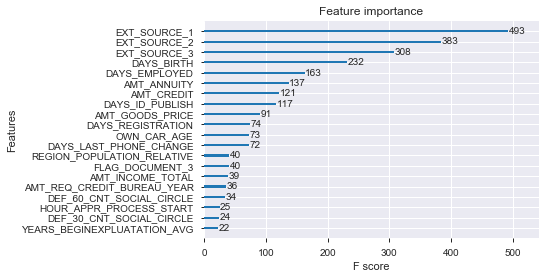

In [148]:
baseline_classification_model(classifier, X_train, y_train, X_test, y_test)

### Relation with the Target - Numerical Columns

Pearson correlation coefficient

    .00-.19 “very weak”
    .20-.39 “weak”
    .40-.59 “moderate”
    .60-.79 “strong”
    .80-1.0 “very strong”

In [97]:
correlations = train.corr(method='pearson')['TARGET'].sort_values()

print('Most positive correlations:\n', correlations.tail(15))
print('\nMost negative correlations:\n', correlations.head(15))

Most positive correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most negative correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


- Inspecting some positive correlations

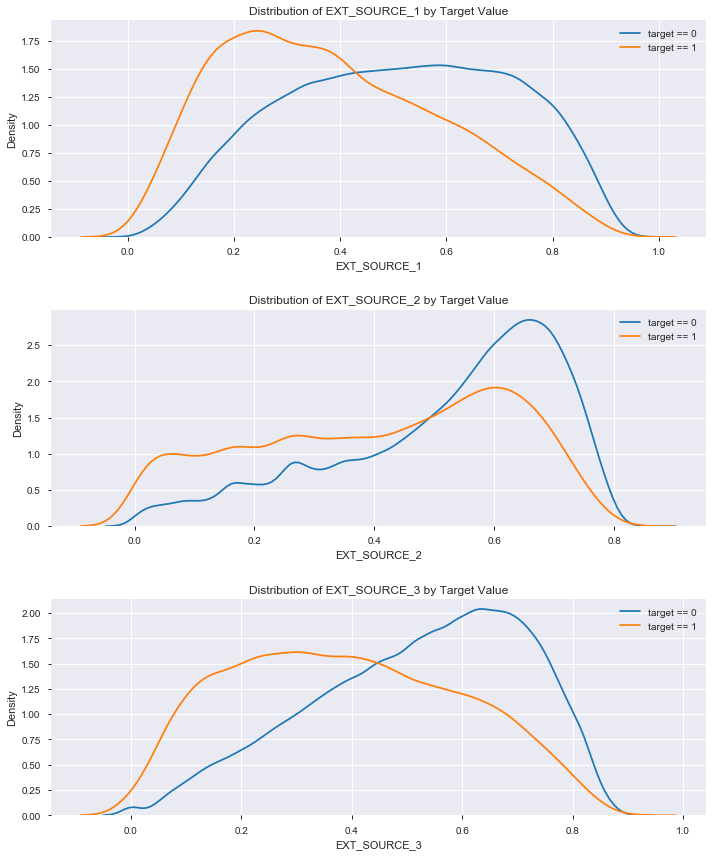

In [113]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(train.loc[train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(train.loc[train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

### Relationship with the target Categorical Variables

In [122]:
def bar_chart(feature):
    bad = train[train['TARGET']==1][feature].value_counts()
    good = train[train['TARGET']==0][feature].value_counts()
    df = pd.DataFrame([bad,good])
    df.index = ['Bad Customer','Good Customer']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

In [135]:
categorical_columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')

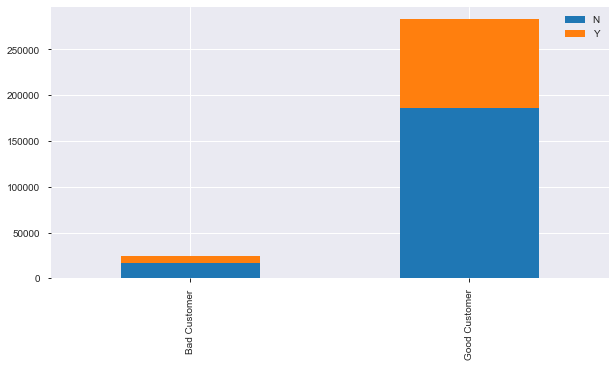

In [123]:
bar_chart('FLAG_OWN_CAR')

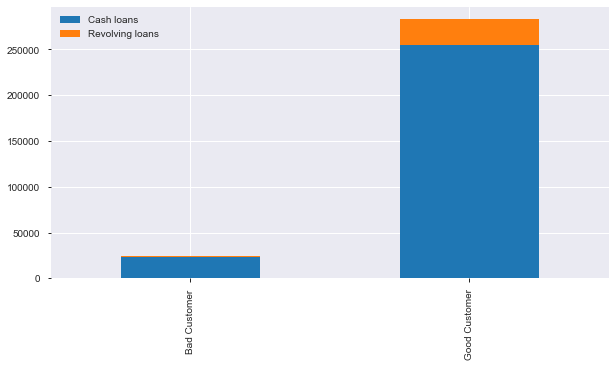

In [136]:
bar_chart('NAME_CONTRACT_TYPE')

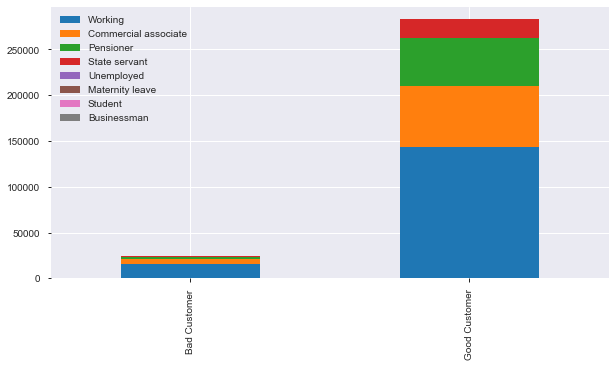

In [137]:
bar_chart('NAME_INCOME_TYPE')